In [ ]:
######################################
## Graham Kerr
## June 2020
## 
## This is adapted from Laura Hayes' routine 
## (http://localhost:8889/notebooks/solar_flare_and_snn.ipynb#Solar-Cycle-and-Solar-Flare-Plots). 
## 
## Shows flares that are White Light Flare (WLFs), initially based on Kyoko Watanabe's survey 
## (Watanabe et al, ApJ 851 2017), and known non-WLFs (that is, they were analysed and no WLF 
## emission was observed). There is observation bias, and not every flare has been checked. So
## the lists are not exhaustive.
##
##
## NOTE: I use cmocean or colorcet tables. You can download them here: 
##          https://matplotlib.org/cmocean/
##          https://colorcet.holoviz.org
##       or just change the cmap options
##
##
######################################

# Solar Cycle and Solar Flare Plots

In this notebook we look at the frequency of solar flares and the occurance with respect to the sunspot number. I'm only focusing on the past 3 solar cycles - i.e Solar Cycles 22, 23, 24 from 1986 - 2019. 


### Data used
* The sunspot number is recorded daily. The data used in this notebook is the monthly sunspot number csv file which can be downloaded here http://www.sidc.be/silso/datafiles (Source: WDC-SILSO, Royal Observatory of Belgium, Brussels).

* The GOES flare catalogue is accessed through the Heliophysics Event Knowledgebase (HEK) using the API provided by SunPy (see https://sunpy.org/ and also the nice example in the gallery [here](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/querying_the_GOES_event_list.html#sphx-glr-generated-gallery-acquiring-data-querying-the-goes-event-list-py))



There are probably some nicer ways to do some of the things in this notebook, but it's just a test bed to play around with the data and make some plots you may need for a talk, some introductions to a thesis etc. 



In [1]:
##
## Import various libraries
##
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
from matplotlib import dates, colors
from matplotlib.ticker import LogLocator
from sunpy.net import hek
from sunpy.time import parse_time
from sunpy.instr.goes import flareclass_to_flux
import sunpy.map
from sunpy.coordinates import frames
from sunpy.data.sample import AIA_171_IMAGE
import pandas as pd
import datetime
from scipy import fftpack
import cmocean
import colorcet as ccet
import astropy.units as u
from astropy.coordinates import SkyCoord
 

In [2]:
##
## Some variables for saving figures later
##
dir1 = './'

saveploteps = False
saveplotpdf = False

In [3]:
##
## Some plot properies
##
##

# font = {'family': 'serif',
#         'color':  'black',
#         'weight': 'medium',
#         'size': 18,
#         }

## You will need to have 'Avenir LT Std' installed. 
## It not you can just swap with the above code.
font = {'family': 'Avenir LT Std',
        'color':  'black',
        'weight': 'medium',
        'size': 18,
        }


plot_params = {'ytick.direction': 'in', 
               'xtick.direction': 'in', 
               'xtick.minor.visible': True,
               'ytick.minor.visible': True,
               'xtick.major.size': 10, 'xtick.minor.size': 5,
               'ytick.major.size': 10, 'ytick.minor.size': 5,
               'ytick.right': False,
               'xtick.top': False,
               'ytick.major.width': 1.5,
               'xtick.major.width': 1.5,
               'ytick.minor.width': 1.5,
               'xtick.minor.width': 1.5,
               'axes.linewidth': 1.5,
               'axes.spines.top': False,
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': False,
               'axes.titlepad' : 18 }

plot_lg_params = {'legend.frameon': False}
#plt.rcParams.update({'font.size': font['size'], 'font.family':font['family'], 'font.weight':font['weight'], 'font.color':font['color']})

plt.rcParams.update({'font.size':font['size'], 'font.family':font['family'], 'font.weight':font['weight']})
plt.rcParams.update({'ytick.direction': plot_params['ytick.direction'],
                     'xtick.direction': plot_params['xtick.direction'],
                     'xtick.minor.visible': plot_params['xtick.minor.visible'],
                     'ytick.minor.visible': plot_params['ytick.minor.visible'],
                     'ytick.major.size':  plot_params['ytick.major.size'], 
                     'ytick.minor.size':  plot_params['ytick.minor.size'],
                     'xtick.major.size':  plot_params['xtick.major.size'],                                
                     'xtick.minor.size':  plot_params['xtick.minor.size'],
                     'ytick.right': plot_params['ytick.right'],
                     'xtick.top': plot_params['xtick.top'],
                     'ytick.major.width': plot_params['ytick.major.width'],
                     'xtick.major.width': plot_params['xtick.major.width'],
                     'ytick.minor.width': plot_params['ytick.minor.width'],
                     'xtick.minor.width': plot_params['xtick.minor.width'],                    
                     'axes.linewidth': plot_params['axes.linewidth'],
                     'axes.spines.top' : plot_params['axes.spines.top'],
                     'axes.spines.bottom' : plot_params['axes.spines.bottom'],
                     'axes.spines.left' : plot_params['axes.spines.left'],
                     'axes.spines.right' : plot_params['axes.spines.right'],
                     'axes.titlepad' : plot_params['axes.titlepad'],
                    })

plt.rcParams.update({'legend.frameon': plot_lg_params['legend.frameon']})


mpl.mathtext.SHRINK_FACTOR = 0.6
mpl.mathtext.GROW_FACTOR = 1 / 0.6

## Lets look at the sunspot number (SSN) data first
We can read the csv into a pandas.DataFrame

In [4]:
def read_ssn():
    """
    Function just to read the SSN data from the downloaded csv file (see above for link)
    """

    ssn = pd.read_csv("SN_m_tot_V2.0.csv", names=['year', 'month', 'decimal_date', \
                                                  'ssn', 'ssn_dev', 'number_obs', 'indicator'], 
             delimiter=';')
    years = ssn['year'].values; months = ssn['month']
    tt = [datetime.datetime(ssn['year'][i], ssn['month'][i], 1) for i in range(len(ssn))]


    ssn['times'] = tt

    return ssn.set_index('times')

In [11]:
##
## Read the sunspot numbers
##
ssn_full = read_ssn()

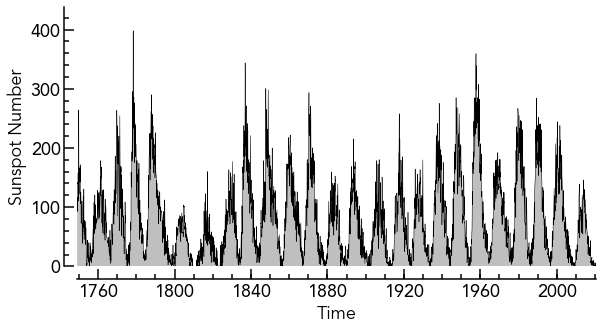

In [8]:
##
## Plot the sunspot number versus time
##

fname_out = 'sunspotnum'

saveploteps = False
saveplotpdf = False

xsize = 8
ysize = 4

fig = plt.figure(figsize=(xsize, ysize))

dx = 0.9
dy = 0.9
y1 = 0.1
x1 = 0.1

ax1 = fig.add_axes([x1, y1, dx, dy])

ax1.set_xlim(ssn_full.index.min(), ssn_full.index.max())
ax1.set_ylim(ssn_full['ssn'].min(), ssn_full['ssn'].max()*1.1)

ax1.set_xlabel('Time')
ax1.set_ylabel('Sunspot Number')

ax1.plot(ssn_full['ssn'], linewidth = 0.5, color = 'black', linestyle = '-')
ax1.fill_between(ssn_full.index, 0, ssn_full['ssn'],alpha = 0.5, facecolor='grey')


ax1.spines["left"].set_position(("axes",-0.025))
ax1.spines["bottom"].set_position(("axes",-0.05))

# ax1.grid(True, which='both', axis='y',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)
# ax1.grid(True, which='both', axis='x',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)


if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()

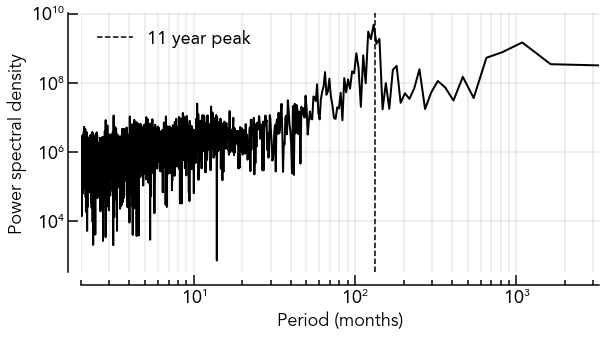

In [20]:
##
## Plot the power spectrum of the sunspot number
##

fname_out = 'powerspec_sunspotnum'

## Take a fourier transform of this to idenify periods - we should obviously identify the 11 year period.
fft = fftpack.fft(ssn_full['ssn'].values)
freq = fftpack.fftfreq(fft.shape[-1], 1)

saveploteps = False
saveplotpdf = False

xsize = 8
ysize = 4

fig = plt.figure(figsize=(xsize, ysize))

dx = 0.9
dy = 0.9
y1 = 0.1
x1 = 0.1

ax1 = fig.add_axes([x1, y1, dx, dy])

ax1.set_xlim(2, len(ssn_full['ssn']))
#ax1.set_ylim(ssn_full['ssn'].min(), ssn_full['ssn'].max()*1.1)

ax1.set_xlabel('Period (months)')
ax1.set_ylabel('Power spectral density')

ax1.plot(1./freq[freq>0], np.abs(fft[freq>0])**2, linewidth = 2, color = 'black', linestyle = '-' )

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.grid(True, which='both', axis='y',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)
ax1.grid(True, which='both', axis='x',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)


ax1.spines["left"].set_position(("axes",-0.025))
ax1.spines["bottom"].set_position(("axes",-0.05))

ax1.axvline(11*12, ls='dashed', color='k', label='11 year peak')

ax1.legend()

if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')

plt.show()


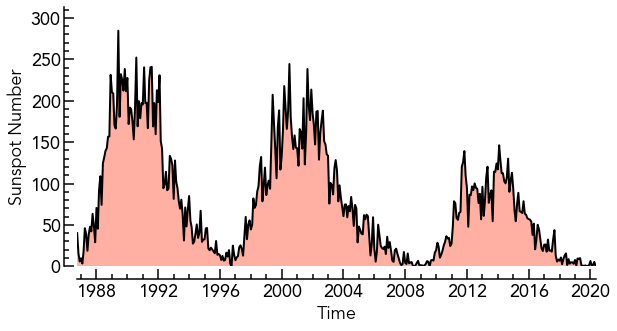

In [13]:
##
## Plot the sunspot number versus time, focusing on cycles 22, 23, 24
##


## Select only from solar cycle 22, 23, & 24
ssn = ssn_full[ssn_full.index>'1986-09-01']

fname_out = 'sunspotnum_cycle22to24'

saveploteps = False
saveplotpdf = False

xsize = 8
ysize = 4

fig = plt.figure(figsize=(xsize, ysize))

dx = 0.9
dy = 0.9
y1 = 0.1
x1 = 0.1

ax1 = fig.add_axes([x1, y1, dx, dy])

ax1.set_xlim(ssn.index.min(), ssn.index.max())
ax1.set_ylim(ssn['ssn'].min(), ssn['ssn'].max()*1.1)

ax1.set_xlabel('Time')
ax1.set_ylabel('Sunspot Number')

ax1.plot(ssn['ssn'], linewidth = 2, color = 'black', linestyle = '-')
ax1.fill_between(ssn.index, 0, ssn['ssn'],alpha = 0.5, facecolor='tomato')


ax1.spines["left"].set_position(("axes",-0.025))
ax1.spines["bottom"].set_position(("axes",-0.05))

# ax1.grid(True, which='both', axis='y',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)
# ax1.grid(True, which='both', axis='x',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)


if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()

## Now lets look at the GOES flare list
The csv I'm using here was created using the HEK client - there a function at the end of this notebook to create the csv if you want.

In [15]:
##
## Load in the flare data (start time, peak, GOES class etc.,)
## This file is creatd by the function at the end of the notebook
##
flares = pd.read_csv('since_1986_c1_solarcycle_flares.csv') 

the data can be inspected first to look at the column names I've given them

In [16]:
##
## Example of what is in 'flares'
##
flares.head()

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,goes_class,flare_times
0,1986-09-08T16:43:00,1986-09-08T16:44:00,1986-09-08T16:55:00,C2.6,4745,0.000003,1986-09-08 16:44:00
1,1986-10-13T00:09:00,1986-10-13T00:11:00,1986-10-13T00:14:00,C1.1,4748,0.000001,1986-10-13 00:11:00
2,1986-10-14T13:38:00,1986-10-14T14:50:00,1986-10-14T15:03:00,C2.2,0,0.000002,1986-10-14 14:50:00
3,1986-10-14T21:54:00,1986-10-14T22:23:00,1986-10-14T22:57:00,C3.3,4747,0.000003,1986-10-14 22:23:00
4,1986-10-15T21:12:00,1986-10-15T21:42:00,1986-10-15T21:42:00,C1.1,0,0.000001,1986-10-15 21:42:00


In [333]:
parse_time(flares['flare_times']).datetime

array([datetime.datetime(1986, 9, 8, 16, 44),
       datetime.datetime(1986, 10, 13, 0, 11),
       datetime.datetime(1986, 10, 14, 14, 50), ...,
       datetime.datetime(2019, 5, 7, 11, 56),
       datetime.datetime(2019, 5, 9, 5, 51),
       datetime.datetime(2019, 5, 15, 19, 24)], dtype=object)

In [268]:
flares['event_starttime'][(np.where(flares['event_starttime'][0] >= 1.0e-4))[0]]

387      1988-01-02T21:11:00
693      1988-04-14T19:34:00
951      1988-06-23T08:56:00
958      1988-06-24T04:18:00
963      1988-06-24T16:03:00
                ...         
37624    2015-05-05T22:05:00
38938    2017-09-06T08:57:00
38939    2017-09-06T11:53:00
38949    2017-09-07T14:20:00
38992    2017-09-10T15:35:00
Name: event_starttime, Length: 349, dtype: object

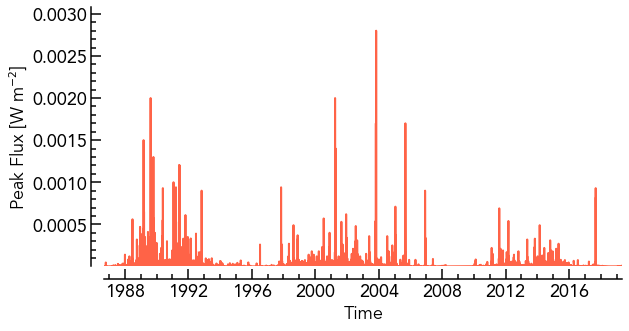

In [248]:
##
## Plot the flare GOES class as a function of time. 
##

fname_out = 'goesflares_cycle22to24'

saveploteps = False
saveplotpdf = False

xsize = 8
ysize = 4

fig = plt.figure(figsize=(xsize, ysize))

dx = 0.9
dy = 0.9
y1 = 0.1
x1 = 0.1

ax1 = fig.add_axes([x1, y1, dx, dy])

ax1.set_xlim(parse_time(flares['flare_times']).datetime[0], parse_time(flares['flare_times']).datetime[-1])
ax1.set_ylim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)

ax1.set_yscale('linear')
ax1.set_xlabel('Time')
ax1.set_ylabel('Peak Flux [W m$^{-2}$]')

ax1.plot(parse_time(flares['flare_times']).datetime,flares['goes_class'], linewidth = 2, color = 'tomato', linestyle = '-')
#ax1.fill_between(ssn.index, 0, ssn['ssn'],alpha = 0.5, facecolor='tomato')


ax1.spines["left"].set_position(("axes",-0.025))
ax1.spines["bottom"].set_position(("axes",-0.05))

# ax1.grid(True, which='both', axis='y',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)
# ax1.grid(True, which='both', axis='x',linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.75)


if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()




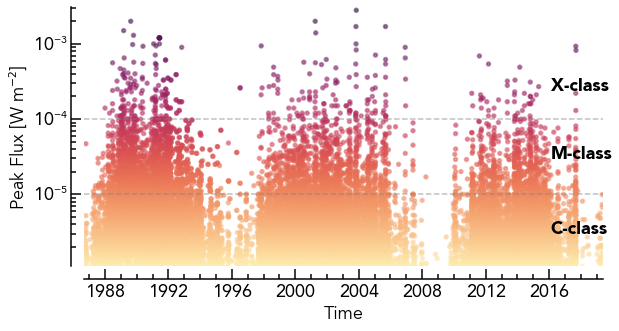

In [230]:
##
## Now plot as a scatter plot, with color as flux magniture
##
fname_out = 'goesflares_cycle22to24_scatter'

saveploteps = False
saveplotpdf = False

xsize = 8
ysize = 4

fig = plt.figure(figsize=(xsize, ysize))

dx = 0.9
dy = 0.9
y1 = 0.1
x1 = 0.1

ax1 = fig.add_axes([x1, y1, dx, dy])

ax1.set_xlim(parse_time(flares['flare_times']).datetime[0], parse_time(flares['flare_times']).datetime[-1])
ax1.set_ylim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Peak Flux [W m$^{-2}$]')

ax1.set_yscale('log')
ax1.scatter(pd.to_datetime(flares['event_peaktime']), flares['goes_class'], linewidth = 2, 
           alpha=0.5, s=12, cmap=cmocean.cm.matter, c=flares['goes_class'], norm=LogNorm())
           #alpha=0.75, s=((flares['goes_class'])/np.max((flares['goes_class'])))*100, cmap='GnBu', c=flares['goes_class'], norm=LogNorm())


ax1.spines["left"].set_position(("axes",-0.025))
ax1.spines["bottom"].set_position(("axes",-0.05))

#ax1.axhline(y=1.0e-3, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)
ax1.axhline(y=1.0e-4, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)
ax1.axhline(y=1.0e-5, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)
ax1.axhline(y=1.0e-6, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)

ax1.text(0.9, 0.125, 'C-class', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax1.text(0.9, 0.4125, 'M-class', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax1.text(0.9, 0.675, 'X-class', color = 'black',transform=ax1.transAxes,fontweight='bold')     




if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()



We can also plot the flares frequency as a histogram - however given there are so many more smaller flares than larger flares (it follows a power law) we should plot this with logarithmically spaced bins

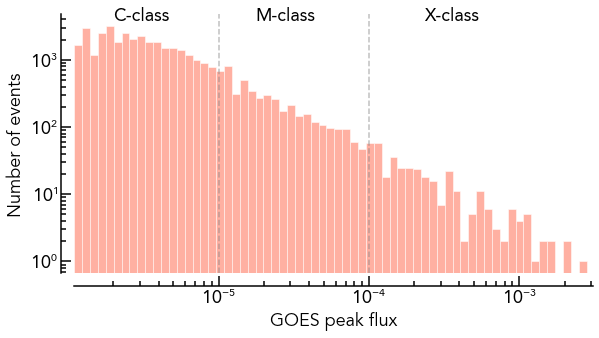

In [195]:
##
## Now plot as a histogram of flare class
##

# first get the linear bins (bin size I just chose a random one)
n, linear_bins = np.histogram(flares['goes_class'], bins=65) 
# now define the log bins
logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

fname_out = 'goesflares_cycle22to24_histogram'

saveploteps = False
saveplotpdf = False

xsize = 8
ysize = 4

fig = plt.figure(figsize=(xsize, ysize))

dx = 0.9
dy = 0.9
y1 = 0.1
x1 = 0.1

ax1 = fig.add_axes([x1, y1, dx, dy])

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('GOES peak flux')
ax1.set_ylabel('Number of events')
ax1.set_xlim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)

n, bins, _ = ax1.hist(flares['goes_class'], bins=logbins, alpha=0.5, color='tomato',edgecolor='white')
#ax1.step(bins[1:],n, color='tomato', lw=2) #overplot step


ax1.spines["left"].set_position(("axes",-0.025))
ax1.spines["bottom"].set_position(("axes",-0.05))

#ax1.axhline(y=1.0e-3, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)
ax1.axvline(x=1.0e-4, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)
ax1.axvline(x=1.0e-5, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)
ax1.axvline(x=1.0e-6, linestyle = '--', color = 'gray', linewidth = 1.5, alpha = 0.5)

ax1.text(0.075, 0.975, 'C-class', color = 'black',transform=ax1.transAxes)     
ax1.text(0.35, 0.975, 'M-class', color = 'black',transform=ax1.transAxes)     
ax1.text(0.675, 0.975, 'X-class', color = 'black',transform=ax1.transAxes)     




if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()



As shown it follows a nice power law shape - to do this properly and find frequency distribution you should probably divide the total number in each bin by the bin width ....

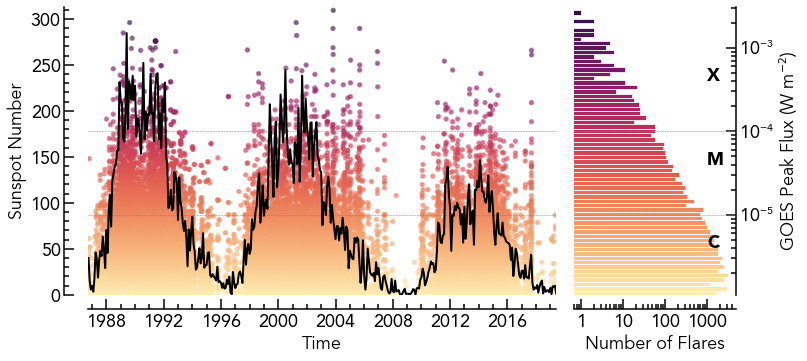

In [234]:
##
## Now combine with sunspot number, with a histogram
##

# first get the linear bins (bin size I just chose a random one)
n, linear_bins = np.histogram(flares['goes_class'], bins=65) 
# now define the log bins
logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

fname_out = 'flares_spn_histo_cycle22to24'

saveploteps = False
saveplotpdf = False

xsize = 10
ysize = 5

fig = plt.figure(figsize=(xsize, ysize))

x1 = 0.1
y1 = 0.1
dx1 = 0.65
dy1 = 0.8
x2 = x1+dx1+0.025
y2 = 0.1
dx2 = 1.0-x2
dy2 = 0.8

ax1 = fig.add_axes([x1, y1, dx1, dy1])
ax2 = fig.add_axes([x2, y2, dx2, dy2])

ax1.set_xlim(ssn.index.min(), ssn.index.max())
ax1.set_ylim(ssn['ssn'].min(), ssn['ssn'].max()*1.1)

ax1.set_xlabel('Time')
ax1.set_ylabel('Sunspot Number')

ax1.spines["left"].set_position(("axes",-0.05))
ax1.spines["bottom"].set_position(("axes",-0.05))
ax1.set_zorder(1) 
ax1.patch.set_visible(False) 

ax1.plot(ssn['ssn'], linewidth = 2, color = 'black', linestyle = '-')


ax3 = ax1.twinx()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

#ax3.spines["right"].set_position(("axes",1.025))
# ax3.spines["bottom"].set_position(("axes",-0.05))

ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labeltop = False) 
ax3.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False,
    labelright = False)
#ax3.grid(True, axis='x', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)
#ax3.grid(True, axis='y', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)

ax3.set_xlim(parse_time(flares['flare_times']).datetime[0], parse_time(flares['flare_times']).datetime[-1])
ax3.set_ylim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)
#ax3.set_xlabel('Time')
#ax1.set_ylabel('Peak Flux [W m$^{-2}$]')

ax3.set_yscale('log')
ax3.scatter(pd.to_datetime(flares['event_peaktime']), flares['goes_class'], linewidth = 2, 
            alpha=0.5, s=12, cmap=cmocean.cm.matter, c=flares['goes_class'], norm=LogNorm())
            #alpha=0.75, s=((flares['goes_class'])/np.max((flares['goes_class'])))*100, cmap='GnBu', c=flares['goes_class'], norm=LogNorm())


    
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)
ax2.set_ylabel('GOES Peak Flux (W m$^{-2}$)')
ax2.set_xlabel('Number of Flares')
ax2.yaxis.set_label_position("right")
ax2.set_xticks([10,100,1000]) 
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax2.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)


Na, binsa, patches = ax2.hist(flares['goes_class'], orientation='horizontal', 
                               bins=logbins, alpha=1.0, edgecolor = 'white',linewidth=0.75)

#ax2.step(Na, binsa[:-1], color='grey', lw=0.5) #overplot step

# # this part is to color the histogram based on bin values
fracs = linear_bins
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
     color = plt.cm.get_cmap(cmocean.cm.matter)(norm(thisfrac))
     thispatch.set_facecolor(color)

ax2.spines["left"].set_position(("axes",-0.05))
ax2.spines["bottom"].set_position(("axes",-0.05))

ax2.spines['right'].set_visible(True)
ax2.spines['left'].set_visible(False)
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelleft=False,
    labelright = True)

ax3.axhline(1e-5, color='grey', lw=0.75, ls='dashed')
ax2.axhline(1e-5, color='grey', lw=0.75, ls='dashed')
ax3.axhline(1e-4, color='grey', lw=0.75, ls='dashed')
ax2.axhline(1e-4, color='grey', lw=0.75, ls='dashed')    

ax2.text(1000, 4e-6, 'C', color='k', fontweight='bold')
ax2.text(1000, 4e-5, 'M', color='k', fontweight='bold')
ax2.text(1000, 4e-4, 'X', color='k', fontweight='bold')


if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()

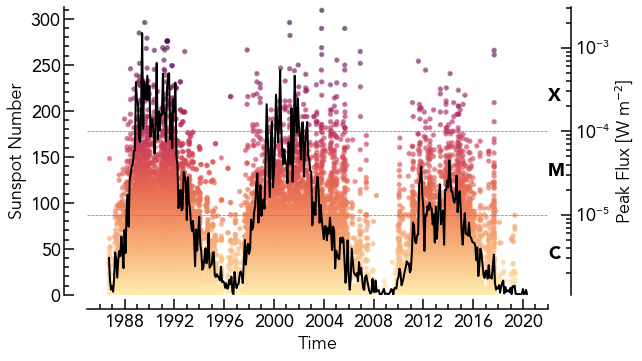

In [294]:
##
## Now combine with sunspot number, without a histogram
##

fname_out = 'flares_spn_cycle22to24'

saveploteps = False
saveplotpdf = False

xsize = 8
ysize = 5

fig = plt.figure(figsize=(xsize, ysize))

x1 = 0.1
y1 = 0.1
dx1 = 0.8
dy1 = 0.8


ax1 = fig.add_axes([x1, y1, dx1, dy1])

#ax1.set_xlim(ssn.index.min(), ssn.index.max())
#ax1.set_xlim(datetime.datetime(2000, 1, 1, 0, 0), ssn.index.max())
ax1.set_ylim(ssn['ssn'].min(), ssn['ssn'].max()*1.1)

ax1.set_xlabel('Time')
ax1.set_ylabel('Sunspot Number')
ax1.xaxis.set_major_locator(dates.YearLocator(4))
ax1.xaxis.set_minor_locator(dates.YearLocator(1))  
ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y'))


ax1.spines["left"].set_position(("axes",-0.05))
ax1.spines["bottom"].set_position(("axes",-0.05))
ax1.set_zorder(1) 
ax1.patch.set_visible(False) 

ax1.plot(ssn['ssn'], linewidth = 2, color = 'black', linestyle = '-')


ax2 = ax1.twinx()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_position(("axes",1.05))
# ax2.spines["bottom"].set_position(("axes",-0.05))
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labeltop = False) 
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelleft=False,
    labelright = True)
#ax2.grid(True, axis='x', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)
#ax2.grid(True, axis='y', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)

#ax2.set_xlim(parse_time(flares['flare_times']).datetime[0], parse_time(flares['flare_times']).datetime[-1])
ax2.set_ylim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)
#ax2.set_xlabel('Time')
ax2.set_ylabel('Peak Flux [W m$^{-2}$]')

ax2.set_yscale('log')
ax2.scatter(pd.to_datetime(flares['event_peaktime']), flares['goes_class'], linewidth = 2, 
            alpha=0.5, s=12, cmap=cmocean.cm.matter, c=flares['goes_class'], norm=LogNorm())
            #alpha=0.75, s=((flares['goes_class'])/np.max((flares['goes_class'])))*100, cmap='GnBu', c=flares['goes_class'], norm=LogNorm())


    
ax2.axhline(1e-5, color='grey', lw=0.75, ls='dashed')
ax2.axhline(1e-4, color='grey', lw=0.75, ls='dashed')    

ax2.text(1.0, 0.125, 'C', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax2.text(1.0, 0.4125, 'M', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax2.text(1.0, 0.675, 'X', color = 'black',transform=ax1.transAxes,fontweight='bold')     


if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()

In [5]:
## 
## Load in the White Light Flare List
## This list is taken from Watanabe et al 2017, ApJ 850
## I copied from pdf to excel. Probably a clever way to 
## do this in a better way than I have, but for now 
## I have split the date into columns, as integers. 
## The next cell will create a datetime object from the 
## first several entries and populate an empty final 
## cell. 
wlflist_Watanabe2017 = pd.read_csv('WLF_List_Watanabe2017.csv') 
wlflist_Watanabe2017.head()
nwlflist_Watanabe2017 = pd.read_csv('NWLF_List_Watanabe2017.csv') 
nwlflist_Watanabe2017.head()

,Year,Month,Day,Hour,Min,GoesClass,Location,StartTime
0,2012,3,5,2,30,X1.1,N19E58,NaN
1,2012,7,12,15,37,X1.4,S13W03,NaN
2,2013,5,15,1,24,X1.2,N12E64,NaN
3,2014,10,25,16,55,X1.0,S10W22,NaN
4,2014,11,7,16,53,X1.6,N14E36,NaN


In [6]:
for ind in range(len(wlflist_Watanabe2017)):
    wlflist_Watanabe2017['StartTime'][ind] = datetime.datetime(
            wlflist_Watanabe2017['Year'][ind],
            wlflist_Watanabe2017['Month'][ind],
            wlflist_Watanabe2017['Day'][ind],
            wlflist_Watanabe2017['Hour'][ind],
            wlflist_Watanabe2017['Min'][ind])
        
wlflist_Watanabe2017.head()

<ipython-input-6-c8fa54b17fa0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wlflist_Watanabe2017['StartTime'][ind] = datetime.datetime(


,Year,Month,Day,Hour,Min,GoesClass,Location,StartTime
0,2011,2,15,1,44,X2.2,S20W10,2011-02-15 01:44:00
1,2011,11,3,20,16,X1.9,N21E64,2011-11-03 20:16:00
2,2012,1,27,17,37,X1.7,N33W85,2012-01-27 17:37:00
3,2012,7,6,23,1,X1.1,S13W59,2012-07-06 23:01:00
4,2012,10,23,3,13,X1.8,S13E58,2012-10-23 03:13:00


In [7]:
for ind in range(len(nwlflist_Watanabe2017)):
    nwlflist_Watanabe2017['StartTime'][ind] = datetime.datetime(
            nwlflist_Watanabe2017['Year'][ind],
            nwlflist_Watanabe2017['Month'][ind],
            nwlflist_Watanabe2017['Day'][ind],
            nwlflist_Watanabe2017['Hour'][ind],
            nwlflist_Watanabe2017['Min'][ind])
        
nwlflist_Watanabe2017.head()

<ipython-input-7-202d5543a79d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nwlflist_Watanabe2017['StartTime'][ind] = datetime.datetime(


,Year,Month,Day,Hour,Min,GoesClass,Location,StartTime
0,2012,3,5,2,30,X1.1,N19E58,2012-03-05 02:30:00
1,2012,7,12,15,37,X1.4,S13W03,2012-07-12 15:37:00
2,2013,5,15,1,24,X1.2,N12E64,2013-05-15 01:24:00
3,2014,10,25,16,55,X1.0,S10W22,2014-10-25 16:55:00
4,2014,11,7,16,53,X1.6,N14E36,2014-11-07 16:53:00


In [8]:
## 
## Convert GOES Class to flux (WLFS)
##
wlflist_Watanabe2017['StartTime'][0]
wlffluxes_Watanabe2017 = np.zeros(len(wlflist_Watanabe2017),dtype = np.float)
for i in range(len(wlflist_Watanabe2017)):
     wlffluxes_Watanabe2017[i] = flareclass_to_flux(wlflist_Watanabe2017['GoesClass'][i]).value


In [9]:
##
## Convert GOES Class to flux (NWLFS)
##
nwlflist_Watanabe2017['StartTime'][0]
nwlffluxes_Watanabe2017 = np.zeros(len(nwlflist_Watanabe2017),dtype = np.float)
for i in range(len(nwlflist_Watanabe2017)):
     nwlffluxes_Watanabe2017[i] = flareclass_to_flux(nwlflist_Watanabe2017['GoesClass'][i]).value



'AvenirLTStd-Black.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'AvenirLTStd-Book.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


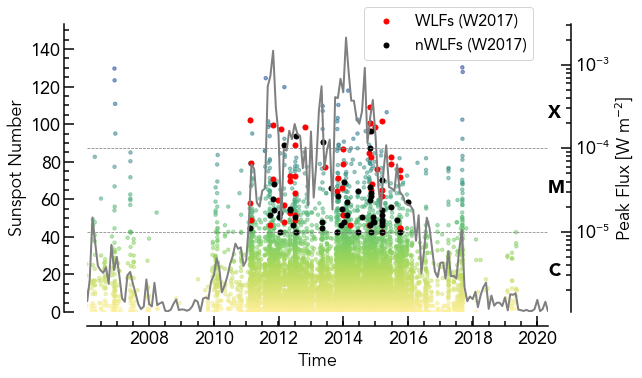

In [22]:
##
## Plot sunspot number, with goes flares, and overlay known White Light Flares
##

## Select only from flares after X date
ssn_2plot = ssn_full[ssn_full.index>'2006-01-01']

## Set up the figure ##
fname_out = 'flares_spn_cycle22to24_WLFs'

#cmapflares = cmocean.cm.gray_r
#cmapflares = cmocean.cm.matter
cmapflares = cmocean.cm.haline_r

saveploteps = False
saveplotpdf = True

xsize = 8
ysize = 5

fig = plt.figure(figsize=(xsize, ysize))

x1 = 0.1
y1 = 0.1
dx1 = 0.8
dy1 = 0.8


ax1 = fig.add_axes([x1, y1, dx1, dy1])

## Plot sunspot number ##

ax1.set_xlim(ssn_2plot.index.min(), ssn_2plot.index.max())
#ax1.set_xlim(datetime.datetime(2010, 1, 1, 0, 0), ssn_2plot.index.max())
ax1.set_ylim(ssn_2plot['ssn'].min(), ssn_2plot['ssn'].max()*1.05)
#ax1.set_ylim([0,200])

ax1.set_xlabel('Time')
ax1.set_ylabel('Sunspot Number')
# ax1.xaxis.set_major_locator(dates.YearLocator(4))
# ax1.xaxis.set_minor_locator(dates.YearLocator(1))  
# ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax1.spines["left"].set_position(("axes",-0.05))
ax1.spines["bottom"].set_position(("axes",-0.05))
ax1.set_zorder(1) 
ax1.patch.set_visible(False) 

ax1.plot(ssn['ssn'], linewidth = 2, color = 'grey', linestyle = '-', alpha =1.0)

## Plot GOES Flux ##
ax2 = ax1.twinx()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_position(("axes",1.05))
# ax2.spines["bottom"].set_position(("axes",-0.05))
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labeltop = False) 
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelleft=False,
    labelright = True)
#ax2.grid(True, axis='x', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)
#ax2.grid(True, axis='y', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)

#ax2.set_xlim(parse_time(flares['flare_times']).datetime[0], parse_time(flares['flare_times']).datetime[-1])
ax2.set_ylim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)
#ax2.set_xlabel('Time')
ax2.set_ylabel('Peak Flux [W m$^{-2}$]')

ax2.set_yscale('log')
ax2.scatter(pd.to_datetime(flares['event_peaktime']), flares['goes_class'], 
            alpha=0.5, s=12, cmap=cmapflares, c=flares['goes_class'], norm=LogNorm())
            #alpha=0.75, s=((flares['goes_class'])/np.max((flares['goes_class'])))*100, cmap='GnBu', c=flares['goes_class'], norm=LogNorm())

ax2.axhline(1e-5, color='grey', lw=0.75, ls='dashed')
ax2.axhline(1e-4, color='grey', lw=0.75, ls='dashed')    

ax2.text(1.0, 0.125, 'C', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax2.text(1.0, 0.4125, 'M', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax2.text(1.0, 0.675, 'X', color = 'black',transform=ax1.transAxes,fontweight='bold')     


## Plot the WLFs ##

ax2.scatter(wlflist_Watanabe2017['StartTime'], wlffluxes_Watanabe2017, s = 25, color = 'red',norm=LogNorm(),label='WLFs (W2017)')
ax2.scatter(nwlflist_Watanabe2017['StartTime'], nwlffluxes_Watanabe2017, s = 25, color = 'black',norm=LogNorm(),label='nWLFs (W2017)')

## Add the legends
leg1 = ax2.legend(loc=(0.60,0.875), fontsize = 16,frameon=True)





if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400,linewidth=2)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()

In [18]:
##
## Extract the latitude and longitude from the flare list
##
wlflat_watanabe = np.zeros(len(nwlflist_Watanabe2017),dtype=float)
wlflong_watanabe = np.zeros(len(nwlflist_Watanabe2017),dtype=float)
nwlflat_watanabe = np.zeros(len(nwlflist_Watanabe2017),dtype=float)
nwlflong_watanabe = np.zeros(len(nwlflist_Watanabe2017),dtype=float)


for ind in range(len(wlflist_Watanabe2017)):
    if wlflist_Watanabe2017['Location'][ind][0] == 'S':
        facns = -1
    if wlflist_Watanabe2017['Location'][ind][0] == 'N':
        facns = 1
    if wlflist_Watanabe2017['Location'][ind][3] == 'E':
        facew = -1
    if wlflist_Watanabe2017['Location'][ind][3] == 'W':
        facew = 1
    wlflat_watanabe[ind] = facns*float(wlflist_Watanabe2017['Location'][ind][1:3])
    wlflong_watanabe[ind] = facew*float(wlflist_Watanabe2017['Location'][ind][4:6])
    
for ind in range(len(nwlflist_Watanabe2017)):
    if nwlflist_Watanabe2017['Location'][ind][0] == 'S':
        facns = -1
    if nwlflist_Watanabe2017['Location'][ind][0] == 'N':
        facns = 1
    if nwlflist_Watanabe2017['Location'][ind][3] == 'E':
        facew = -1
    if nwlflist_Watanabe2017['Location'][ind][3] == 'W':
        facew = 1
    nwlflat_watanabe[ind] = facns*float(nwlflist_Watanabe2017['Location'][ind][1:3])
    nwlflong_watanabe[ind] = facew*float(nwlflist_Watanabe2017['Location'][ind][4:6])

<ipython-input-31-92ad99331dc3>:7: RuntimeWarning: invalid value encountered in power
  aiascaled = sunpy.map.Map(aia.data**0.75, aia.meta)


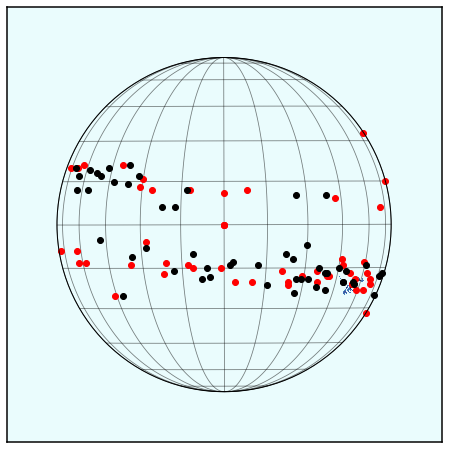

In [31]:
##
## Overlay the positions of the WLFs and NWLFS on a map
##

## Create the map
aia = sunpy.map.Map(AIA_171_IMAGE)
aiascaled = sunpy.map.Map(aia.data**0.75, aia.meta)
# aia.data[np.where(aia.data < 10000)] = 0.0
# aiascaled2 = sunpy.map.Map(aia.data, aia.meta)


## Set up the figure ##
fname_out = 'flarepos_cycle22to24_WLFs'

saveploteps = False
saveplotpdf = False

mapback = cmocean.cm.ice_r

xsize = 8
ysize = 8

fig = plt.figure(figsize=(xsize, ysize))

x1 = 0.1
y1 = 0.1
dx1 = 0.8
dy1 = 0.8


ax1 = fig.add_axes([x1, y1, dx1, dy1])


# Define the flare positions in heliographic Stonyhurst coordinates
wlfflarepos = SkyCoord(lat=wlflat_watanabe*u.deg, lon=wlflong_watanabe*u.deg, observer=aia.observer_coordinate, obstime=aia.date, frame=frames.HeliographicStonyhurst)
nwlfflarepos = SkyCoord(lat=nwlflat_watanabe*u.deg, lon=nwlflong_watanabe*u.deg, observer=aia.observer_coordinate, obstime=aia.date, frame=frames.HeliographicStonyhurst)

 
# Make the plot
ax1 = plt.subplot(projection=aia)
aiascaled2.plot(cmap = mapback, title = False,axes=ax1)  # Plot the map
ax1.plot_coord(wlfflarepos, 'ro')  # Plot a blue X
ax1.plot_coord(nwlfflarepos, color='black',marker='o',linestyle='none') 
aiascaled.draw_limb(color='black')
aiascaled.draw_grid(color='black')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
# ax1.spines["left"].set_position(("axes",.05))
# ax1.spines["bottom"].set_position(("axes",-0.05))
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labeltop = False) 
ax1.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False,
    labelright = False)
ax1.coords.grid(False)


if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400,linewidth=2)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()

'AvenirLTStd-Black.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'AvenirLTStd-Book.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


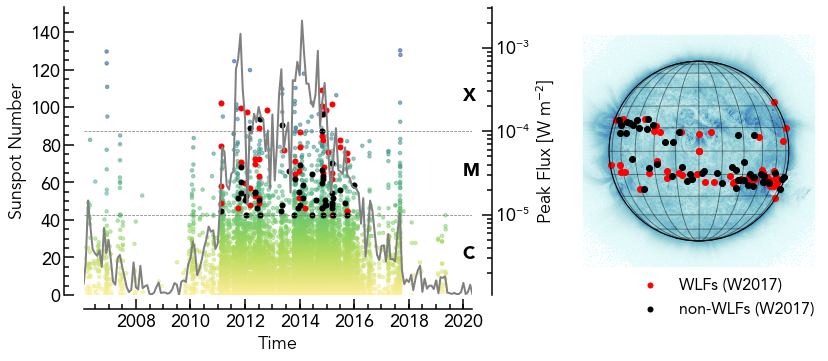

In [27]:
##
## Plot sunspot number, with goes flares, and overlay known White Light Flares
##

## Select only from flares after X date
ssn_2plot = ssn_full[ssn_full.index>'2006-01-01']

## Set up the figure ##
fname_out = 'flarepos_spn_cycle22to24_WLFs'

#cmapflares = cmocean.cm.gray_r
#cmapflares = cmocean.cm.matter
cmapflares = cmocean.cm.haline_r

saveploteps = False
saveplotpdf = True

xsize = 12
ysize = 5

fig = plt.figure(figsize=(xsize, ysize),frameon=False)

x1 = 0.1
y1 = 0.1
dx1 = 0.45
dy1 = 0.8

x2 = 0.65
dx2 = 0.325
y2 = 0.175
dy2 = 0.65

ax1 = fig.add_axes([x1, y1, dx1, dy1])
#ax3 = fig.add_axes([x2, y2, dx2, dy2])


## Plot sunspot number ##

ax1.set_xlim(ssn_2plot.index.min(), ssn_2plot.index.max())
#ax1.set_xlim(datetime.datetime(2010, 1, 1, 0, 0), ssn_2plot.index.max())
ax1.set_ylim(ssn_2plot['ssn'].min(), ssn_2plot['ssn'].max()*1.05)
#ax1.set_ylim([0,200])

ax1.set_xlabel('Time')
ax1.set_ylabel('Sunspot Number')
# ax1.xaxis.set_major_locator(dates.YearLocator(4))
# ax1.xaxis.set_minor_locator(dates.YearLocator(1))  
# ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax1.spines["left"].set_position(("axes",-0.05))
ax1.spines["bottom"].set_position(("axes",-0.05))
ax1.set_zorder(1) 
ax1.patch.set_visible(False) 

ax1.plot(ssn['ssn'], linewidth = 2, color = 'grey', linestyle = '-', alpha =1.0)

## Plot GOES Flux ##
ax2 = ax1.twinx()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_position(("axes",1.05))
# ax2.spines["bottom"].set_position(("axes",-0.05))
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labeltop = False) 
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelleft=False,
    labelright = True)
#ax2.grid(True, axis='x', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)
#ax2.grid(True, axis='y', which='both', linestyle = '-', linewidth = 0.35, color = 'grey', alpha = 0.25)

#ax2.set_xlim(parse_time(flares['flare_times']).datetime[0], parse_time(flares['flare_times']).datetime[-1])
ax2.set_ylim(flares['goes_class'].min(), flares['goes_class'].max()*1.1)
#ax2.set_xlabel('Time')
ax2.set_ylabel('Peak Flux [W m$^{-2}$]')

ax2.set_yscale('log')
ax2.scatter(pd.to_datetime(flares['event_peaktime']), flares['goes_class'], 
            alpha=0.5, s=12, cmap=cmapflares, c=flares['goes_class'], norm=LogNorm())
            #alpha=0.75, s=((flares['goes_class'])/np.max((flares['goes_class'])))*100, cmap='GnBu', c=flares['goes_class'], norm=LogNorm())

ax2.axhline(1e-5, color='grey', lw=0.75, ls='dashed')
ax2.axhline(1e-4, color='grey', lw=0.75, ls='dashed')    

ax2.text(0.975, 0.125, 'C', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax2.text(0.975, 0.4125, 'M', color = 'black',transform=ax1.transAxes,fontweight='bold')     
ax2.text(0.975, 0.675, 'X', color = 'black',transform=ax1.transAxes,fontweight='bold')     


## Plot the WLFs ##

ax2.scatter(wlflist_Watanabe2017['StartTime'], wlffluxes_Watanabe2017, s = 25, color = 'red',norm=LogNorm(),label='WLFs (W2017)')
ax2.scatter(nwlflist_Watanabe2017['StartTime'], nwlffluxes_Watanabe2017, s = 25, color = 'black',norm=LogNorm(),label='non-WLFs (W2017)')

## Add the legends
leg1 = ax2.legend(loc=(1.4,-0.1), fontsize = 16,frameon=False)



# Define the flare positions in heliographic Stonyhurst coordinates
wlfflarepos = SkyCoord(lat=wlflat_watanabe*u.deg, lon=wlflong_watanabe*u.deg, observer=aia.observer_coordinate, obstime=aia.date, frame=frames.HeliographicStonyhurst)
nwlfflarepos = SkyCoord(lat=nwlflat_watanabe*u.deg, lon=nwlflong_watanabe*u.deg, observer=aia.observer_coordinate, obstime=aia.date, frame=frames.HeliographicStonyhurst)

with plt.rc_context({'axes.edgecolor':'white' }):  # context manager start
    # Temporary rc parameters in effect

    # Make the plot
    ax3 = fig.add_subplot(projection=aiascaled,position = [x2, y2, dx2, dy2],frame_on=False)
    aiascaled.plot(cmap = mapback, title = False)  # Plot the map
    ax3.plot_coord(wlfflarepos, 'ro')  # Plot a blue X
    ax3.plot_coord(nwlfflarepos, color='black',marker='o',linestyle='none') 
    aiascaled.draw_limb(color='black')
    aiascaled.draw_grid(color='black')

    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    # ax1.spines["left"].set_position(("axes",.05))
    # ax1.spines["bottom"].set_position(("axes",-0.05))
    ax3.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labeltop = False) 
    ax3.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        labelright = False)
    ax3.coords.grid(False)

    ax3.spines['right'].set_color('white')
    ax3.spines['left'].set_color('white')
    ax3.spines['top'].set_color('white')
    ax3.spines['bottom'].set_color('white')



if (saveplotpdf): plt.savefig(dir1+fname_out+'.pdf', format='pdf', bbox_inches = 'tight', dpi=400,linewidth=2)

## Note that if you want to save an eps file you will have to set a non-opentype CFF font
if (saveploteps): plt.savefig(dir1+fname_out+'.eps',bbox_inches = 'tight', format='eps')



plt.show()

## Here's a function to generate the GOES csv file used in this notebook 

Just note that at the moment querying the HEK is super slow - don't know why, probably should look into it .....

In [ ]:
def make_goes_flare_csv():
    
    client = hek.HEKClient()
    event_type = 'FL'

    tstart = '1986/09/01'
    tend = '2020/06/16'

    import time
    t1 = time.time()
    result_m1 = client.search(hek.attrs.Time(tstart, tend),
                              hek.attrs.EventType(event_type),
                              hek.attrs.FL.GOESCls > 'C1.0',
                              hek.attrs.OBS.Observatory == 'GOES')

    print(time.time() - t1)

    new_table = result_m1[['event_starttime', 'event_peaktime',
                           'event_endtime', 'fl_goescls', 'ar_noaanum', ]]

    def get_goes_class(all_data):
        goes_class = []
        goes_class_index = []
        for i in range(len(all_data)):
            #print(i)
            try:
                if all_data[i]['fl_goescls'][0] == 'C':
                    gc = float(all_data[i]['fl_goescls'][1:])*(1e-6)
                    gc1 = 'C'
                elif all_data[i]['fl_goescls'][0] == 'M':
                    gc = float(all_data[i]['fl_goescls'][1:])*(1e-5)
                    gc1 = 'M'
                elif all_data[i]['fl_goescls'][0] == 'X':
                    gc = float(all_data[i]['fl_goescls'][1:])*(1e-4)
                    gc1 = 'X'          
                else:
                    print ('somethings wrong')
            except:
                gc = 0
                print(i)
            goes_class.append(gc)
            goes_class_index.append(gc1)
        return goes_class

    goes_class = get_goes_class(new_table)
    new_table['goes_class'] = goes_class

    flare_times = parse_time(new_table['event_peaktime']).datetime
    new_table['flare_times'] = flare_times

    new_table = new_table[new_table['goes_class']!=0]

    new_table = unique(new_table, keys='event_starttime')

    new_table.write('since_1986_c1_solarcycle_flares.csv', format='csv')